<a href="https://colab.research.google.com/github/saurabhsingh-create/Time-Series/blob/main/Grocery_Sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install pystan
!pip install fbprophet
import fbprophet
from fbprophet import Prophet
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
print(os.getcwd())

from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content


In [8]:
data = pd.read_excel("Demand Planning- Assignment.xlsx",sheet_name = "Data", skiprows=2)

def transform_raw_data(df):
    df.columns = df.iloc[0,:]
    df =df.iloc[2:,2:df.shape[1]-1].reset_index(drop = True).set_index("Hour")
    col_map = df.columns
    df = df.T
    df.reset_index(inplace = True)
    df.rename({0: "Date2"}, inplace = True, axis=1)
    df.head()
    df =df.melt(id_vars=["Date2"], 
            var_name="hour", 
            value_name="Sales")
    return df,col_map

df1,cols_for_mapping = transform_raw_data(data)
df1.head()

,Date2,hour,Sales
0,6-Sep,7,5
1,7-Sep,7,6
2,8-Sep,7,8
3,9-Sep,7,15
4,10-Sep,7,8


In [103]:

def create_template(sd, ed):
    tm =pd.Series(pd.date_range(start= sd,end=ed))
    temp = pd.concat([tm, pd.Series(cols_for_mapping)], axis =1)
    temp.columns = ["Date1", "Date2"]
    temp['key'] =0
    # date_list
    hours = pd.DataFrame({'hour':list((range(24)))})
    hours["key"] = 0
    temp =  temp.merge(hours,on='key', how='outer')
    return temp

temp_df = create_template(sd = "2021-09-06", ed = "2021-10-24")

temp_df.drop(columns = ["key"], inplace = True)
temp_df = temp_df.merge(df1, on = ["Date2", "hour"], how = "left" )
temp_df["Sale_hour"] = np.where(temp_df.Sales.isnull(), 1,0)
temp_df.Sales = temp_df.Sales.fillna(0)
temp_df.drop("Date2", axis =1, inplace = True)
temp_df["ds"] = pd.to_datetime(temp_df['Date1']+pd.to_timedelta(temp_df['hour'],unit='h'))
temp_df['weekday'] = temp_df['ds'].dt.dayofweek
temp_df["Sunday_flag"] = np.where(temp_df['weekday'] ==6,1, 0)
temp_df.tail(25)

,Date1,hour,Sales,Sale_hour,ds,weekday,Sunday_flag
1151,2021-10-23,23,0,1,2021-10-23 23:00:00,5,0
1152,2021-10-24,0,0,1,2021-10-24 00:00:00,6,1
1153,2021-10-24,1,0,1,2021-10-24 01:00:00,6,1
1154,2021-10-24,2,0,1,2021-10-24 02:00:00,6,1
1155,2021-10-24,3,0,1,2021-10-24 03:00:00,6,1
1156,2021-10-24,4,0,1,2021-10-24 04:00:00,6,1
1157,2021-10-24,5,0,1,2021-10-24 05:00:00,6,1
1158,2021-10-24,6,0,1,2021-10-24 06:00:00,6,1
1159,2021-10-24,7,10,0,2021-10-24 07:00:00,6,1
1160,2021-10-24,8,42,0,2021-10-24 08:00:00,6,1


In [34]:
final_df = temp_df[[ "ds", "Sales" ]]
final_df.columns = ["ds", "y"]
final_df.info()
# temp_df['hour'] = pd.to_datetime(temp_df['hour'], format='%H:%M:%S')
# pd.to_datetime(temp_df['Date1'] + ' ' + temp_df['hour'])
# pd.to_datetime(temp_df['Date1']+pd.to_timedelta(temp_df['hour'],unit='h'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1175
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1176 non-null   datetime64[ns]
 1   y       1176 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 27.6 KB


In [35]:
m = Prophet(interval_width = 0.95)
model = m.fit(final_df)
model

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [39]:
future = m.make_future_dataframe(periods=10,freq='H')
forecast = m.predict(future)
forecast.head(24)
# future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-06 00:00:00,18.316564,-24.820660,16.831899,18.316564,18.316564,-22.391318,-22.391318,-22.391318,-23.661428,-23.661428,-23.661428,1.270110,1.270110,1.270110,0.0,0.0,0.0,-4.074754
1,2021-09-06 01:00:00,18.327819,-21.017277,19.699400,18.327819,18.327819,-19.434833,-19.434833,-19.434833,-20.421157,-20.421157,-20.421157,0.986323,0.986323,0.986323,0.0,0.0,0.0,-1.107014
2,2021-09-06 02:00:00,18.339075,-22.835042,15.221610,18.339075,18.339075,-21.733524,-21.733524,-21.733524,-22.437411,-22.437411,-22.437411,0.703887,0.703887,0.703887,0.0,0.0,0.0,-3.394449
3,2021-09-06 03:00:00,18.350330,-29.084383,11.958203,18.350330,18.350330,-26.503891,-26.503891,-26.503891,-26.928906,-26.928906,-26.928906,0.425015,0.425015,0.425015,0.0,0.0,0.0,-8.153560
4,2021-09-06 04:00:00,18.361586,-31.110644,9.737142,18.361586,18.361586,-28.951944,-28.951944,-28.951944,-29.103804,-29.103804,-29.103804,0.151860,0.151860,0.151860,0.0,0.0,0.0,-10.590358
5,2021-09-06 05:00:00,18.372841,-28.848948,13.740116,18.372841,18.372841,-26.332105,-26.332105,-26.332105,-26.218591,-26.218591,-26.218591,-0.113514,-0.113514,-0.113514,0.0,0.0,0.0,-7.959264
6,2021-09-06 06:00:00,18.384097,-21.432664,18.969313,18.384097,18.384097,-19.205400,-19.205400,-19.205400,-18.836251,-18.836251,-18.836251,-0.369149,-0.369149,-0.369149,0.0,0.0,0.0,-0.821304
7,2021-09-06 07:00:00,18.395352,-12.916682,29.325094,18.395352,18.395352,-9.666146,-9.666146,-9.666146,-9.052931,-9.052931,-9.052931,-0.613215,-0.613215,-0.613215,0.0,0.0,0.0,8.729206
8,2021-09-06 08:00:00,18.406607,-1.300952,39.054232,18.406607,18.406607,0.795566,0.795566,0.795566,1.639593,1.639593,1.639593,-0.844027,-0.844027,-0.844027,0.0,0.0,0.0,19.202174
9,2021-09-06 09:00:00,18.417863,10.386468,49.805140,18.417863,18.417863,11.436418,11.436418,11.436418,12.496480,12.496480,12.496480,-1.060062,-1.060062,-1.060062,0.0,0.0,0.0,29.854281


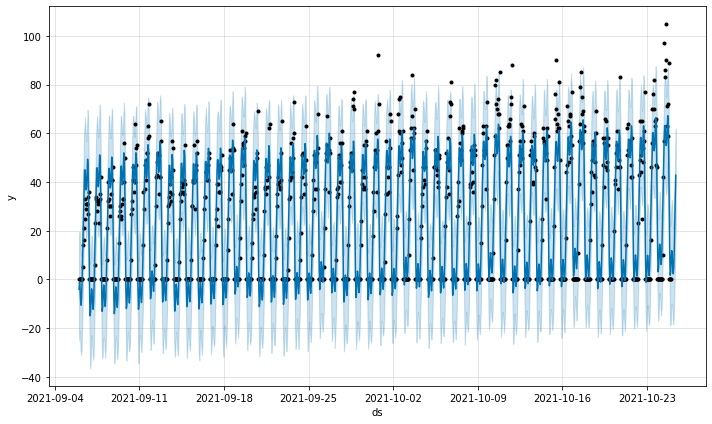

In [40]:
plot1 = m.plot(forecast)

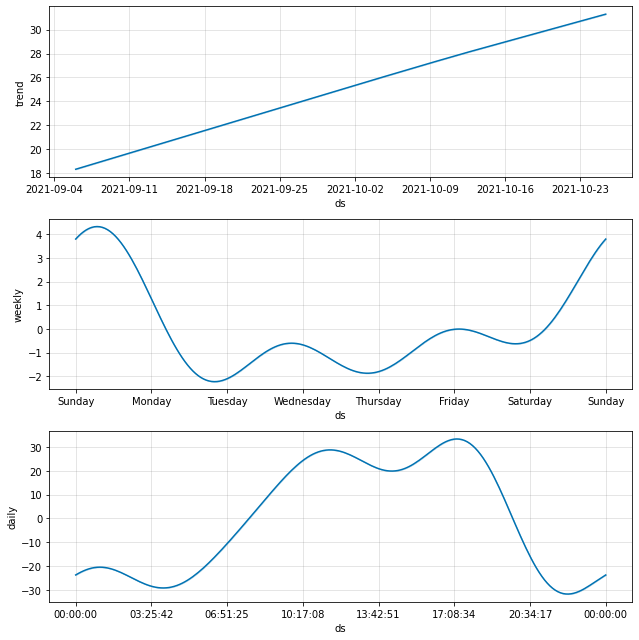

In [41]:
plt2 = m.plot_components(forecast)
#Weekly and daily sesonality exist

In [104]:
final_df = temp_df[['ds', 'Sales','Sale_hour'	,	'Sunday_flag']]
final_df.rename(columns = {"Sales":"y"}, inplace = True)
final_df.head()

,ds,y,Sale_hour,Sunday_flag
0,2021-09-06 00:00:00,0,1,0
1,2021-09-06 01:00:00,0,1,0
2,2021-09-06 02:00:00,0,1,0
3,2021-09-06 03:00:00,0,1,0
4,2021-09-06 04:00:00,0,1,0


In [105]:
train=final_df[final_df['ds'] < '2021-10-11']
test=final_df[(final_df['ds'] >= '2021-10-11')]
print(train.shape)
print(test.shape)

(840, 4)
(336, 4)


In [106]:
m = Prophet(interval_width=0.95,daily_seasonality=True)
m.add_regressor('Sale_hour',standardize=False)
m.add_regressor('Sunday_flag',standardize=False)


In [107]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [108]:
future = m.make_future_dataframe(periods=336, freq='H')
future.tail()

,ds
1171,2021-10-24 19:00:00
1172,2021-10-24 20:00:00
1173,2021-10-24 21:00:00
1174,2021-10-24 22:00:00
1175,2021-10-24 23:00:00


In [109]:
future['Sale_hour'] = final_df['Sale_hour']
future['Sunday_flag'] = final_df['Sunday_flag']

In [110]:
future

,ds,Sale_hour,Sunday_flag
0,2021-09-06 00:00:00,1,0
1,2021-09-06 01:00:00,1,0
2,2021-09-06 02:00:00,1,0
3,2021-09-06 03:00:00,1,0
4,2021-09-06 04:00:00,1,0
5,2021-09-06 05:00:00,1,0
6,2021-09-06 06:00:00,1,0
7,2021-09-06 07:00:00,0,0
8,2021-09-06 08:00:00,0,0
9,2021-09-06 09:00:00,0,0


In [111]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1171,2021-10-24 19:00:00,61.217545,45.207361,76.880514
1172,2021-10-24 20:00:00,18.139999,3.550903,33.759129
1173,2021-10-24 21:00:00,11.052602,-4.891902,26.854766
1174,2021-10-24 22:00:00,8.075193,-7.156574,22.288567
1175,2021-10-24 23:00:00,8.361843,-7.371589,22.518878


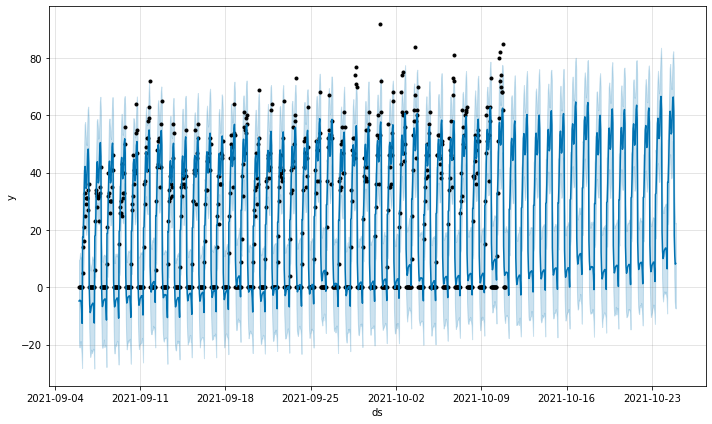

In [112]:
fig1 = m.plot(forecast)

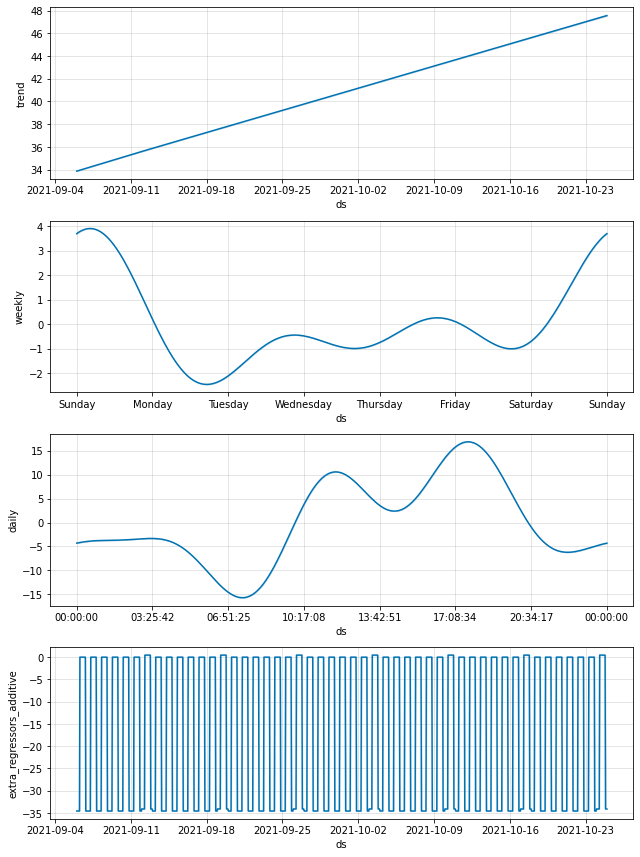

In [113]:
fig2 = m.plot_components(forecast)

In [122]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [125]:
predictions = forecast[['ds','yhat']].iloc[840:,:]
pred = predictions['yhat']
print(test['y'].mean())
print(rmse( test['y'], pred))
print(mape(test['y'], pred))
# mean_absolute_percentage_error(test['y'], pred)

29.49702380952381
12.144658917071219
25.09919765990124
